In [6]:
import numpy as np
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
import matplotlib.pyplot as plt
import csv
import pandas as pd

In [7]:
class randomForest(object):
    def __init__(self, n_estimators, max_depth, max_features, random_seed=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_seed = random_seed
        self.row_indices = []
        self.feature_indices = []
        self.out_of_bag = []
        self.decision_trees = [sklearn.tree.DecisionTreeClassifier(max_depth=None, criterion='entropy') for i in range(n_estimators)]

    def bootstrap(self, num_training, num_features, random_seed = None):
        np.random.seed(seed = self.random_seed)
        for i in range(self.n_estimators):
            total = set(list(range(num_training)))
            row_indices, col_indices = np.random.choice(num_training, num_training), np.random.choice(num_features, int(num_features * self.max_features), replace=False)
            total = total - set(row_indices)
            self.row_indices.append(row_indices)
            self.feature_indices.append(col_indices)
            self.out_of_bag.append(total)
    
    def fit_rforest(self, x, y):
        self.bootstrap(np.shape(x)[0], np.shape(x)[1])
        for i in range(self.n_estimators):
            bsX = x[self.row_indices[i]][:,self.feature_indices[i]]
            bsY = y[self.row_indices[i]]
            self.decision_trees[i].fit(bsX, bsY)

    def accuracy(self, X, y):
        accuracy = []
        for i in range(len(X)):
            predictions = []
            for j in range(self.n_estimators):
                if i in self.out_of_bag[j]:
                    predictions.append(self.decision_trees[j].predict(np.reshape(X[i][self.feature_indices[j]], (1,-1)))[0])
            if len(predictions) > 0:
                accuracy.append(np.sum(predictions == y[i]) / float(len(predictions)))
        return np.mean(accuracy)


1.0
1.0


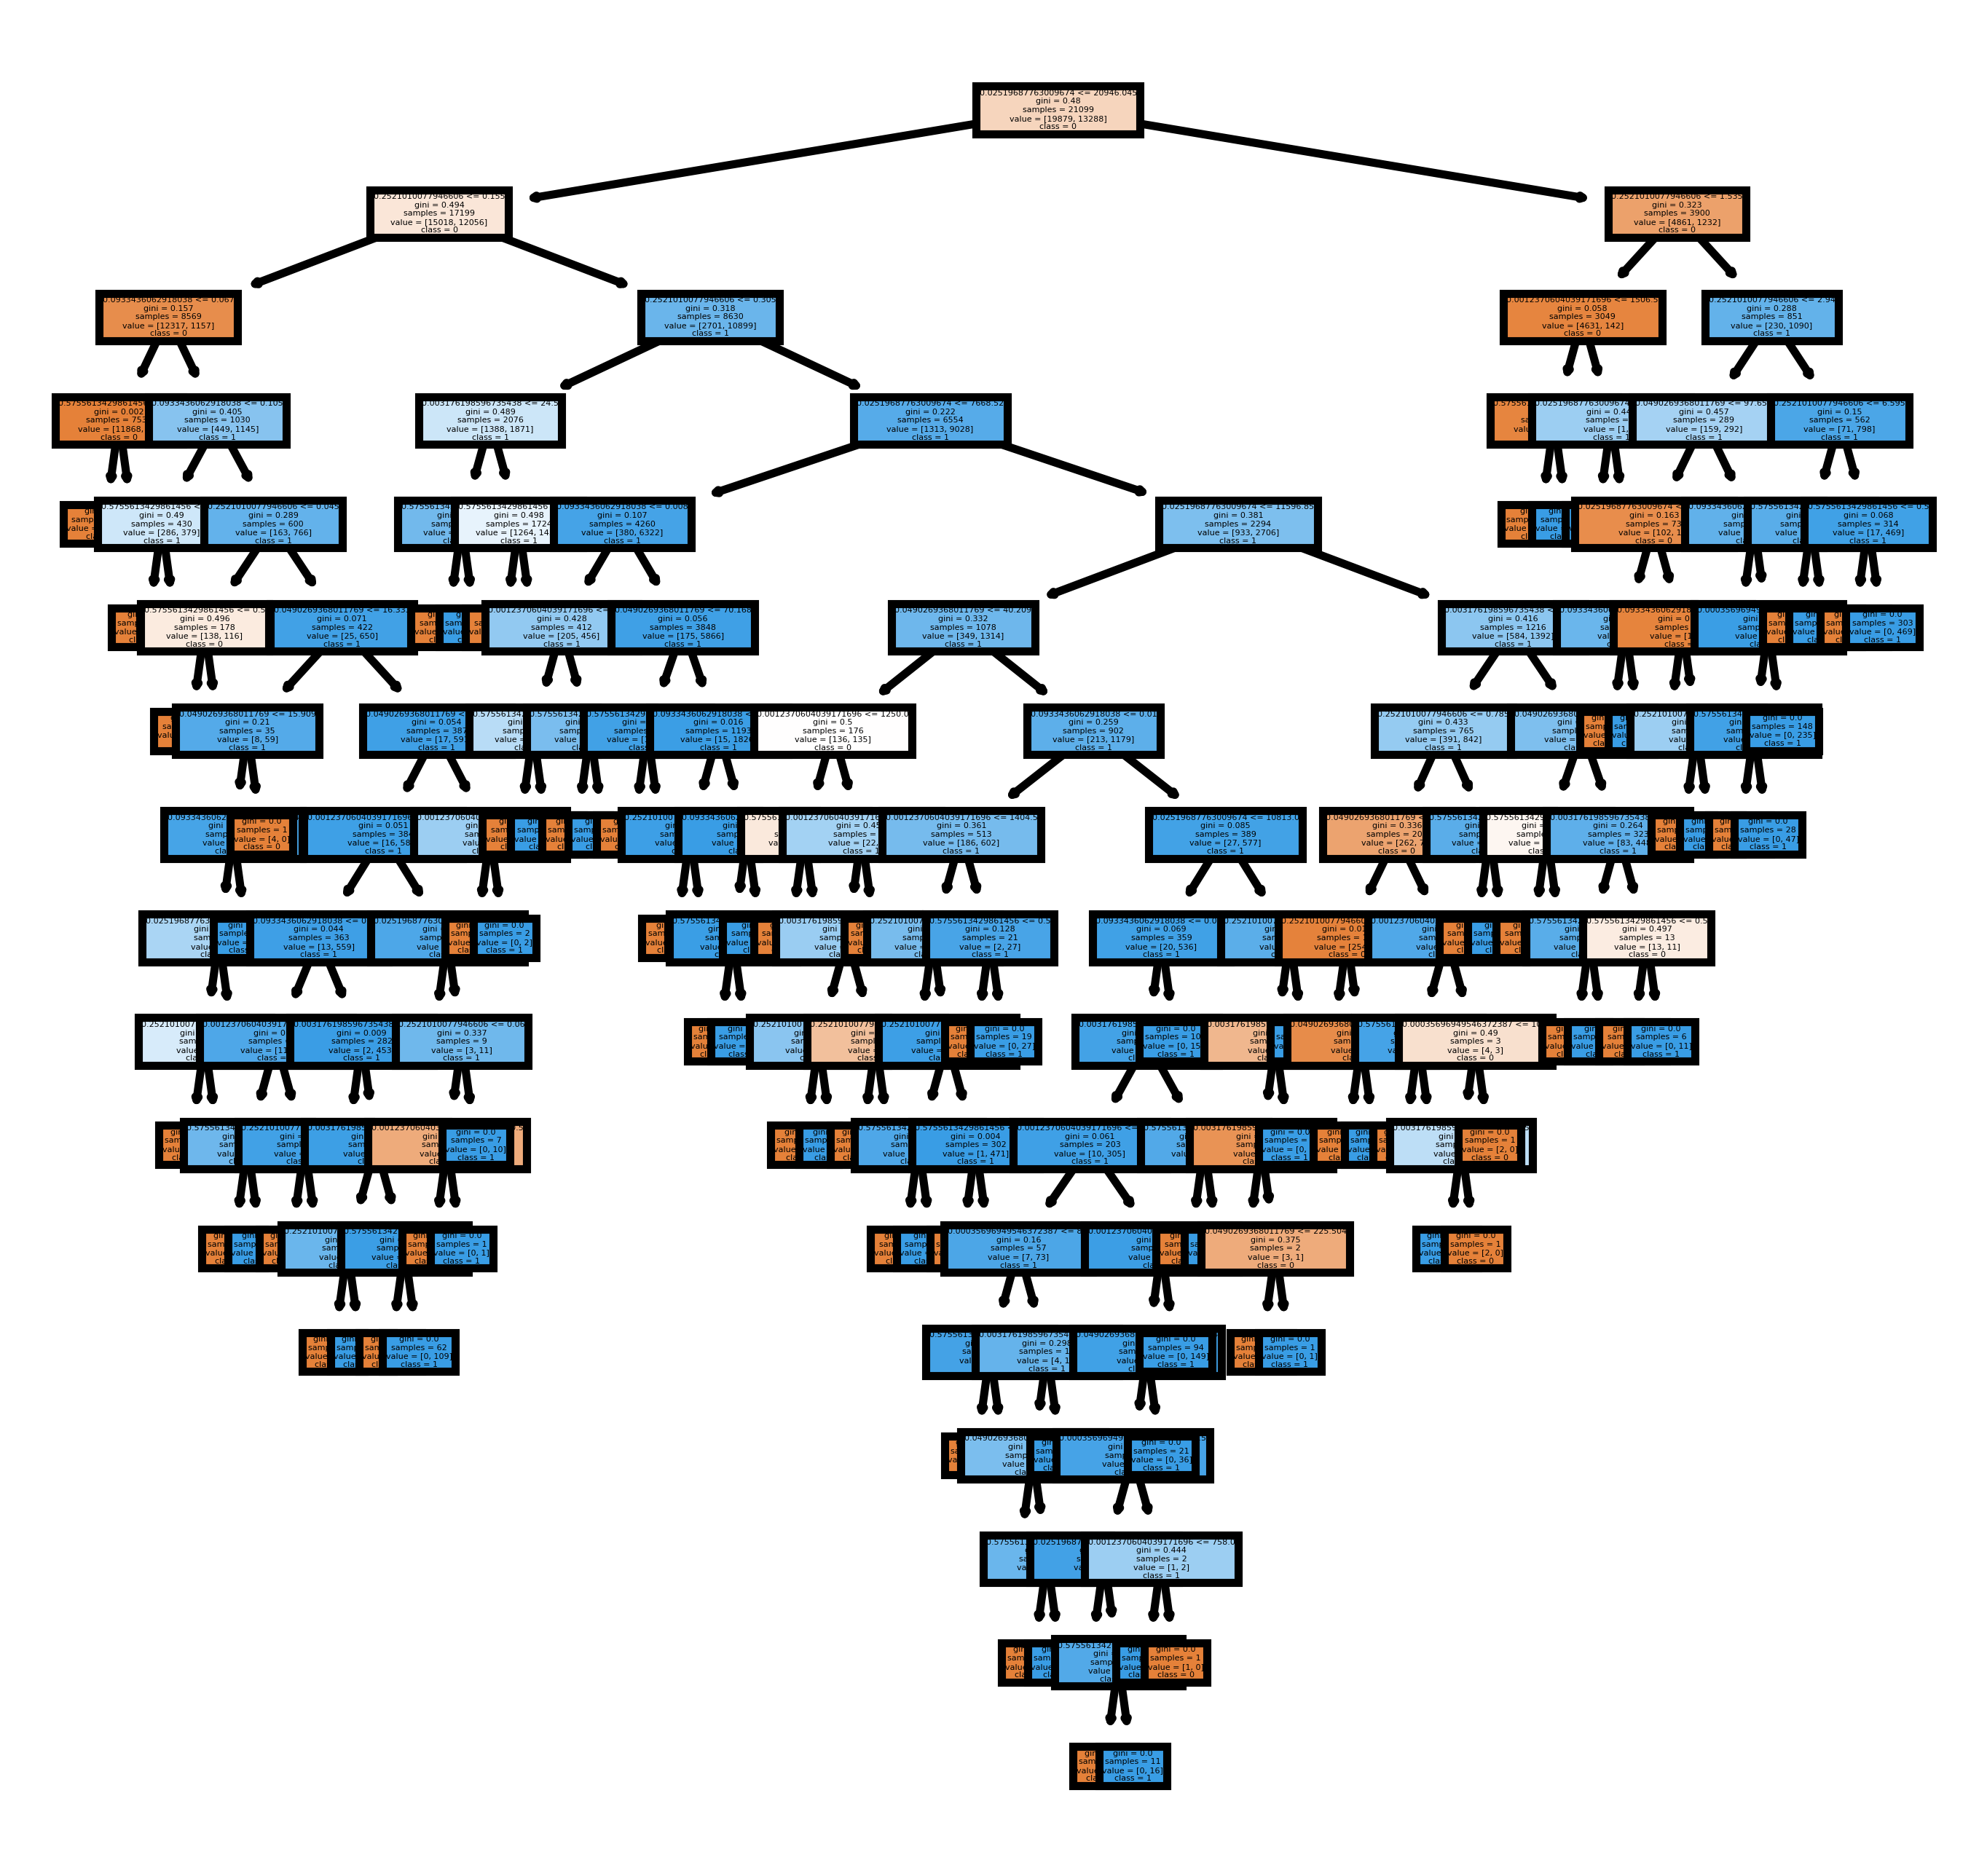

In [8]:
csv_file = open('KickStarterData_nb.csv', encoding="utf-8")
csv_reader = csv.reader(csv_file, delimiter=',')

csv_list = list(csv_reader)
#remove one for the feature titles
totalN = len(csv_list) - 1
#remove 2 for the id and the y column
D = len(csv_list[1]) - 2

#remove the feature titles
csv_list.pop(0)
#split into x and y, remove id
nparray = np.array(csv_list)

#shape of X: (331675, 6)
X = nparray[0:totalN,1:]
#shape of y: (331675,)
y = nparray[:, D+1]


#split into training and testing data
train = int(totalN*0.1)
Xtrain = X[:train]
ytrain = y[:train]

Xtest = X[train+1:]
ytest = y[train+1:]


random_forest = sklearn.ensemble.RandomForestClassifier(bootstrap=True)
random_forest.fit(Xtrain, ytrain)
ypredicted = random_forest.predict(Xtest)

accuracy = sklearn.metrics.accuracy_score(ytest,ypredicted)
print(accuracy)

totalCorrect = 0
for i in range(np.shape(ytest)[0]):
    if ytest[i] == ypredicted[i]:
        totalCorrect += 1

print(totalCorrect/np.shape(ytest)[0])

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
sklearn.tree.plot_tree(random_forest.estimators_[0],
               feature_names = random_forest.feature_importances_, 
               class_names=random_forest.classes_,
               filled = True);
fig.savefig('rf_individualtree.png')


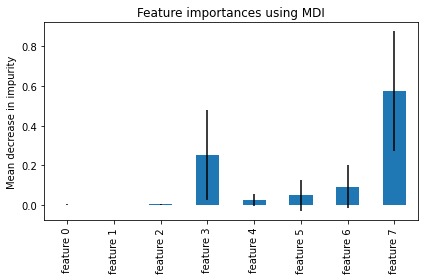

In [9]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
importances = random_forest.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()